In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import torch

from skimage import io

%matplotlib inline

In [2]:
from utils import adjust_sar_contrast, compute_building_score, plot_images

sys.path.append('..')
from spacenet6_model.configs.load_config import get_config_with_previous_experiment
from spacenet6_model.datasets import SpaceNet6TestDataset
from spacenet6_model.models import get_model
from spacenet6_model.transforms import get_augmentation, get_preprocess

In [3]:
# select previous experiment to load
exp_id = 64
exp_log_dir = None  # None: use default

# select device to which the model is loaded
cuda = False
if cuda:
    device = 'cuda'
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
else:
    device = 'cpu'
    os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [4]:
# overwrite default config with previous experiment
config = get_config_with_previous_experiment(exp_id=exp_id, exp_log_dir=exp_log_dir)

# overwrite additional hyper parameters
config.MODEL.DEVICE = device

config.freeze()

print(config)

DATALOADER:
  TEST_BATCH_SIZE: 16
  TEST_NUM_WORKERS: 8
  TRAIN_BATCH_SIZE: 24
  TRAIN_NUM_WORKERS: 8
  TRAIN_SHUFFLE: True
  VAL_BATCH_SIZE: 16
  VAL_NUM_WORKERS: 8
EVAL:
  MAIN_METRIC: iou/building_footprint
  METRICS: ['iou']
EXP_ID: 64
INPUT:
  BUILDING_DIR: /data/spacenet6/footprint_boundary_mask/v_01/labels
  CLASSES: ['building_footprint', 'building_boundary']
  IMAGE_DIR: /data/spacenet6/spacenet6/train
  IMAGE_TYPE: SAR-Intensity
  MEAN_STD_DIR: /data/spacenet6/image_mean_std/
  TEST_IMAGE_DIR: /data/spacenet6/spacenet6/test_public/SAR-Intensity
  TRAIN_VAL_SPLIT_DIR: /data/spacenet6/split
  TRAIN_VAL_SPLIT_ID: 3
LOG_ROOT: /logs
MODEL:
  ACTIVATION: sigmoid
  ARCHITECTURE: unet
  BACKBONE: efficientnet-b5
  DEVICE: cpu
  ENCODER_PRETRAINED_FROM: imagenet
  FPN_DECODER_DROPOUT: 0.2
  IN_CHANNELS: 4
  PSPNET_DROPOUT: 0.2
  WEIGHT: /weights/exp_0064/model_best.pth
SOLVER:
  EPOCHS: 260
  FOCAL_LOSS_GAMMA: 2.0
  LOSSES: ['dice', 'bce']
  LOSS_WEIGHTS: [1.0, 1.0]
  LR: 0.0001
  LR_

In [5]:
model = get_model(config)
model.eval();

In [6]:
preprocessing = get_preprocess(config, is_test=True)
augmentation = get_augmentation(config, is_train=False)

test_dataset = SpaceNet6TestDataset(
    config,
    augmentation=augmentation,
    preprocessing=preprocessing
)

test_dataset_vis = SpaceNet6TestDataset(
    config,
    augmentation=augmentation,
    preprocessing=None
)

In [7]:
channel_footprint = config.INPUT.CLASSES.index('building_footprint')
channel_boundary = config.INPUT.CLASSES.index('building_boundary')

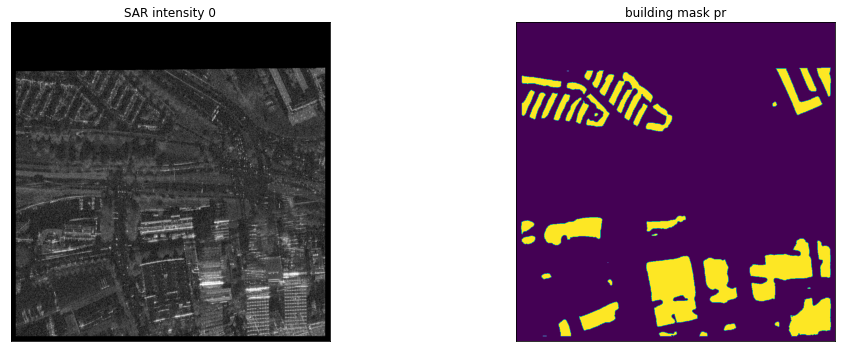

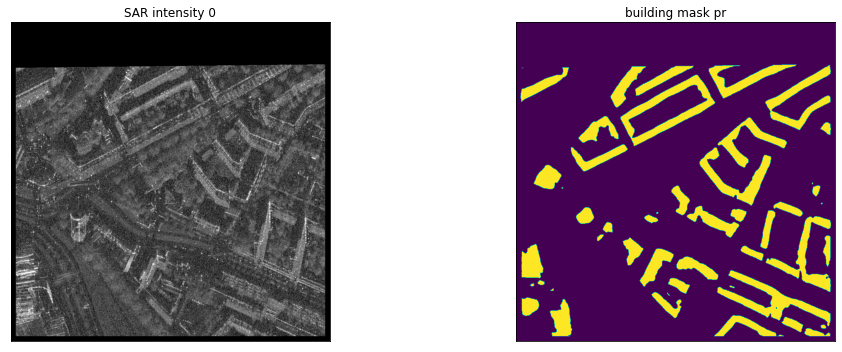

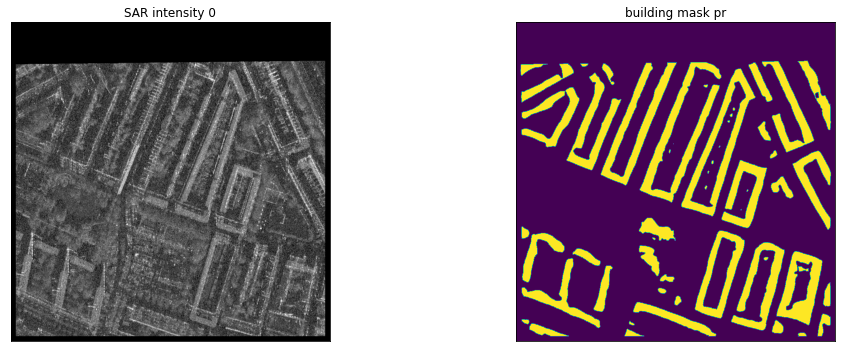

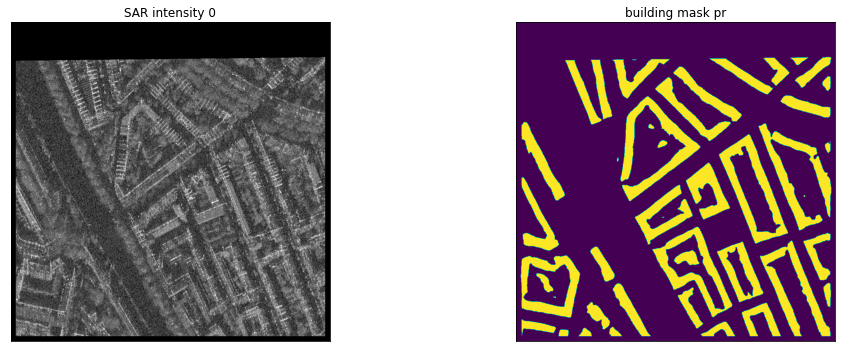

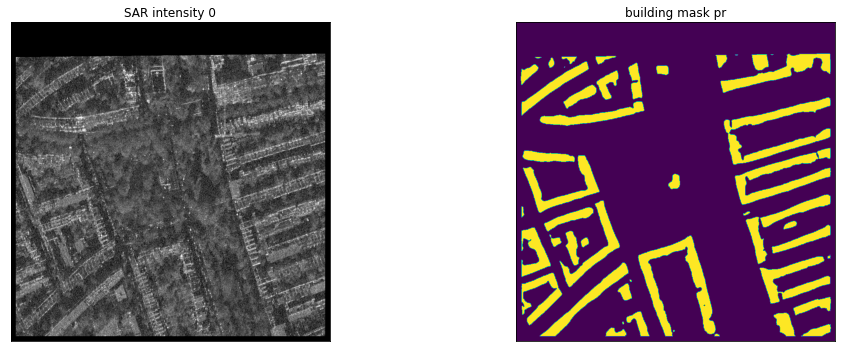

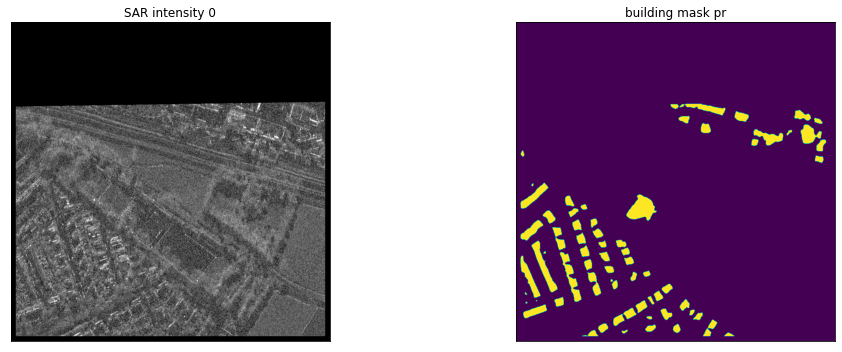

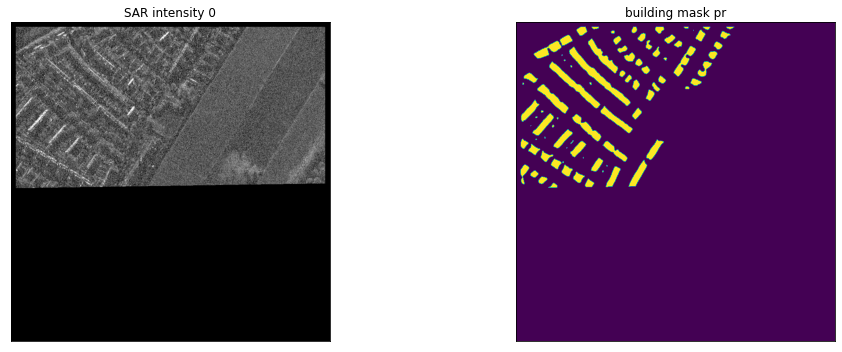

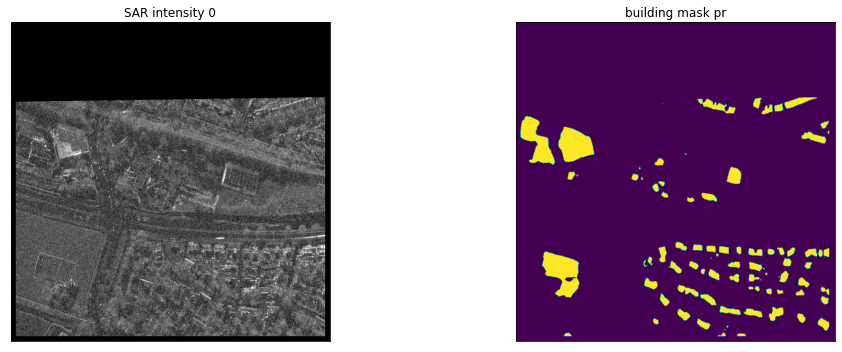

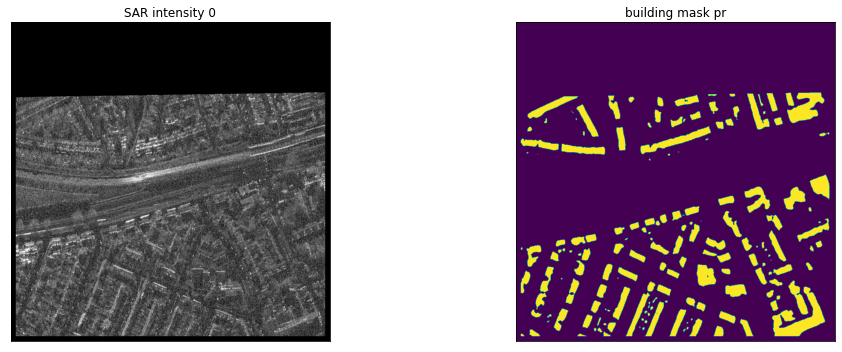

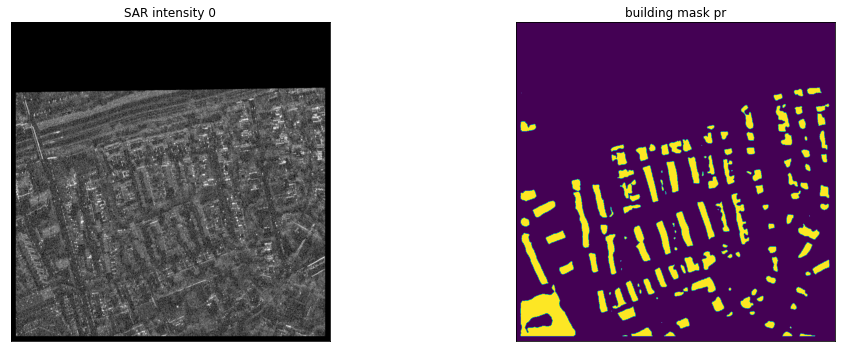

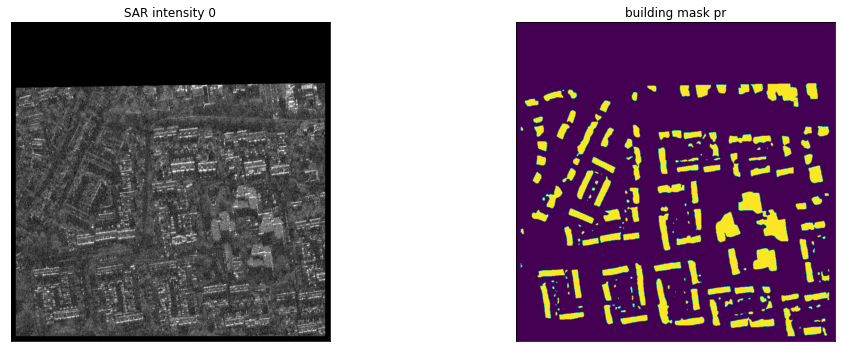

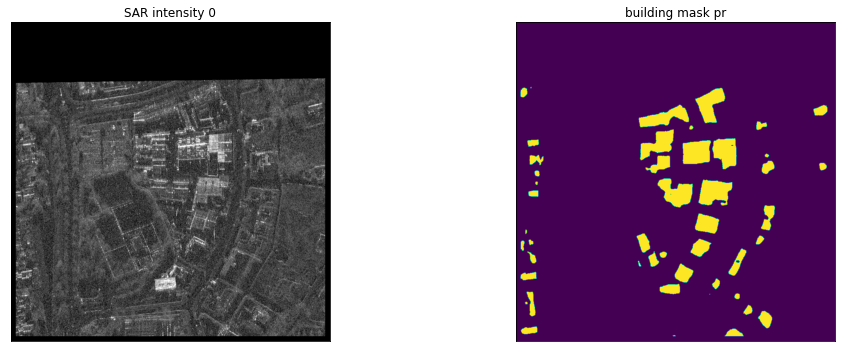

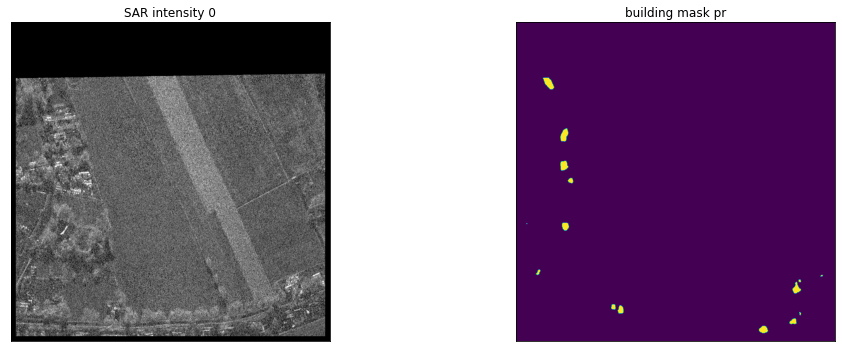

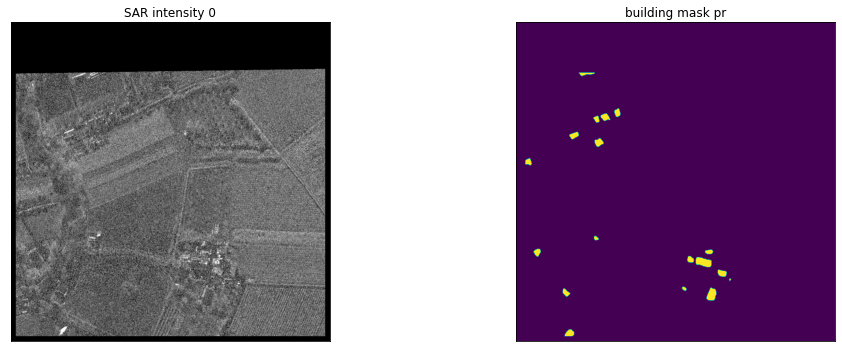

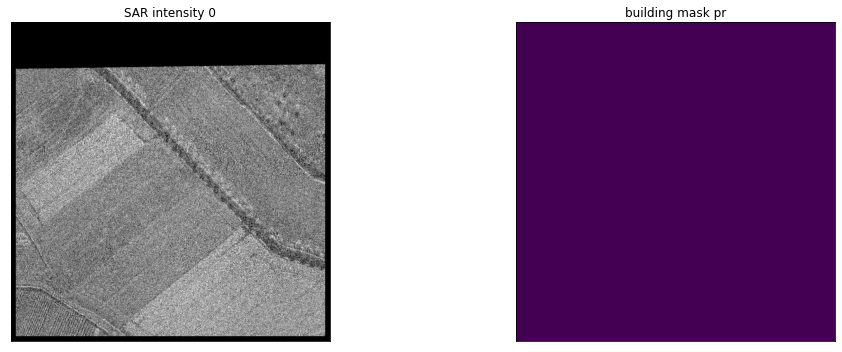

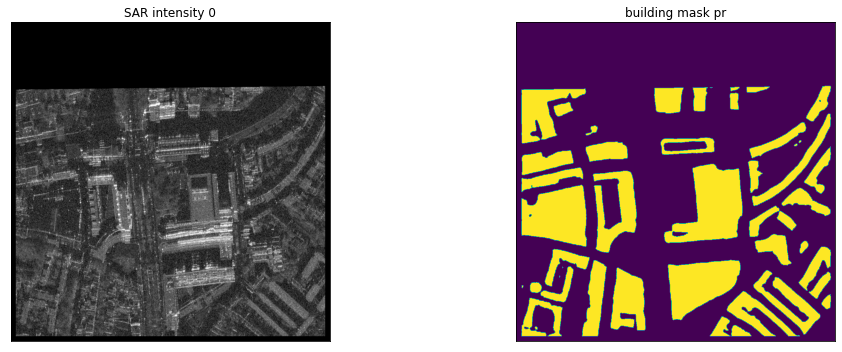

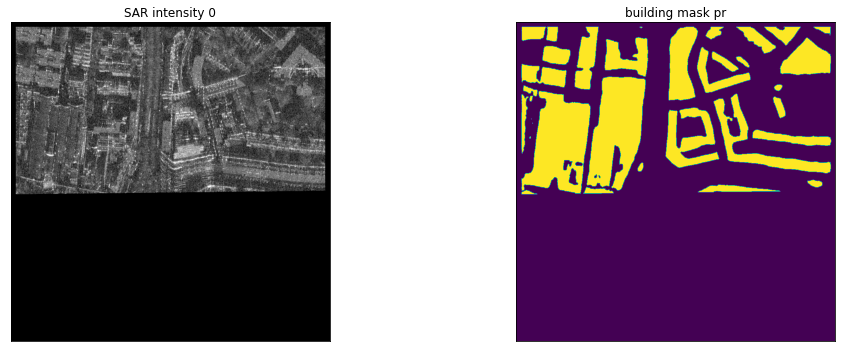

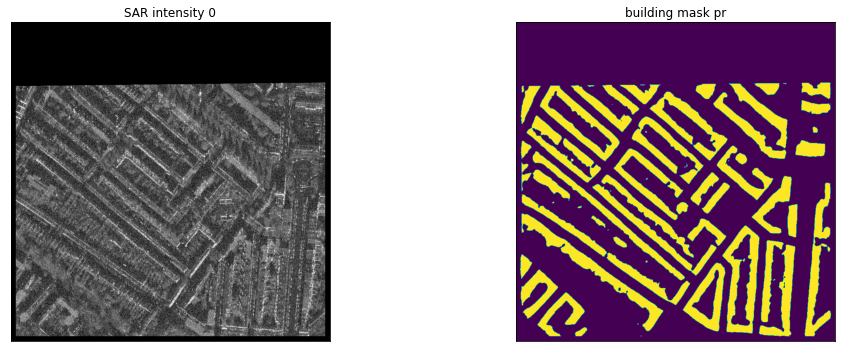

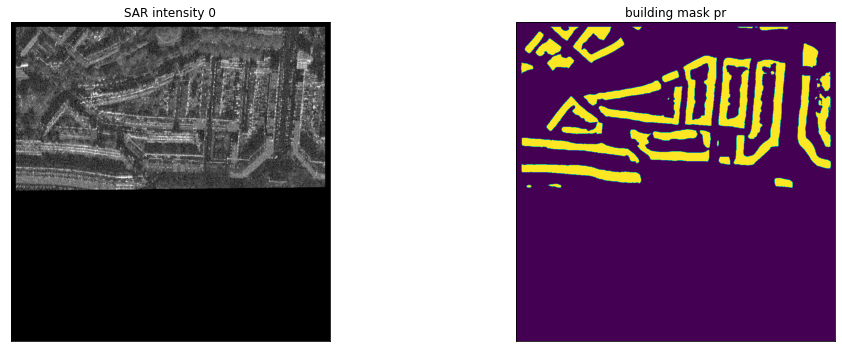

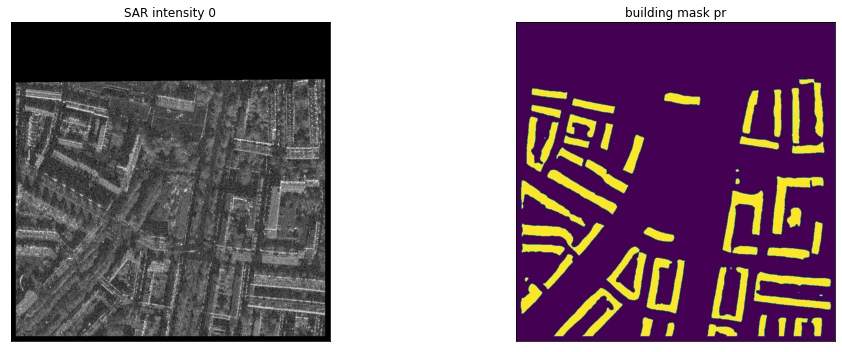

In [8]:
score_thresh = 0.5
alpha = 1.0

start_index = 900
N = 20

for i in range(start_index, start_index + N):
    image_vis = test_dataset_vis[i]['image']
    image = test_dataset[i]['image']
    
    x_tensor = torch.from_numpy(image).to(config.MODEL.DEVICE).unsqueeze(0)
    pr_score = model.module.predict(x_tensor)
    pr_score = pr_score.squeeze()
    pr_score = (pr_score.squeeze().cpu().numpy())
    
    pr_score_building = compute_building_score(
        pr_score[channel_footprint],
        pr_score[channel_boundary],
        alpha=alpha
    )
    pr_mask = pr_score_building > score_thresh
    
    rotated = test_dataset[i]['rotated']
    if rotated:
        image_vis = np.flipud(np.fliplr(image_vis))
        pr_mask = np.flipud(np.fliplr(pr_mask))
    
    plot_images(
        SAR_intensity_0=(adjust_sar_contrast(image_vis[:, :, 0]), 'gray'),
        building_mask_pr=(pr_mask, 'viridis')
    )